<a href="https://colab.research.google.com/github/Teasotea/textSummarization/blob/main/SentRanking_TextSummarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of the [TextRank](https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/) Algorithm

# Import Libraries

In [1]:
!pip install transformers sentencepiece
!pip install sentence_transformers

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 42.5 MB/s 
     |████████████████████████████████| 596 kB 41.0 MB/s 
     |████████████████████████████████| 880 kB 32.9 MB/s 
     |████████████████████████████████| 6.6 MB 21.9 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=efb5dd7db88d2d8a8a00b8114900d523846e8649bb2d7b7d1e012aac32c2b614
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 79 kB 3.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=803b036dd054a9fc5b049fb0cb4e6429557c5

In [121]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time
from sklearn.metrics.pairwise import cosine_similarity
pd.set_option('display.max_colwidth', None)

In [3]:
# mount gdrive to save models
from pathlib import Path
from google.colab import drive

drive.mount('/content/gdrive')

GDRIVE = '/content/gdrive/MyDrive/text_summ'
WORKDIR = GDRIVE + '/sent_ranking/'
Path(WORKDIR).mkdir(parents=True, exist_ok=True)

%cd  '/content/gdrive/MyDrive/text_summ/sent_ranking'

Mounted at /content/gdrive
/content/gdrive/MyDrive/text_summ/sent_ranking


# Load Data

In [43]:
conversation_df = pd.read_csv('https://raw.githubusercontent.com/Teasotea/textSummarization/main/data/session.csv', delimiter = "\t", header=None)
conversation_df = conversation_df.set_axis(['text'], axis=1, inplace=False)
conversation_df.style.set_properties(**{'text-align': 'left'})

,text
0,"Психолог: Добрый день, меня зовут Ирина. Ольга, у нас с вами на сегодня назначена консультация. Надеюсь, что наш разговор будет приятным и полезным. Расскажите с каким запросом вы пришли на нашу первую встречу?"
1,"Ольга: Добрый день, это моя первая консультация в жизни. Я не особо понимаю что именно нужно говорить. Но у меня накопилось достаточно много всего и мне просто хотелось поговорить о том, что сейчас происходит с моей жизнью, ну много чего, конечно, как и у всех, все таки война, переезды, куча всего короче. Просто хотелось чтобы кто-то услышал, помог мне немного разобраться в себе."
2,"Психолог: Ольга, действительно сейчас многие проживают события к которым сложно быть готовым. Давайте начнем понемногу разбираться. Расскажите о себе. Где вы сейчас находитесь, в каких условиях живете, какие события происходят вокруг вас?"
3,"Ольга: Сейчас я чувствую себя относительно в безопасности. Мы переехали из Киева на западную Украину. Здесь можно сказать, что тихо, но я не особо понимаю что происходит. Мне словно приходится начинать все с нуля. Деньги немного есть, ээээ ну там на пару месяцев хватит, но нужно искать работу. Не пойму нужно учится на новую специальность или попытаться найти работу менеджером, как раньше? Хотя кому эти менеджеры нужны, ничего толком не работает, наверно повезло людям которые сохранили работу, прям как-то радостно за них. Потерять финансовую стабильность мне реально тяжело, ждать что что-то наладится, но ничего не наладится же. Ну даже если наладится то не скоро, рада что могла себе обеспечить эту финансовую подушку. Я реально уже думала что можно и начать инвестировать но блин, реально никогда не знаешь, теперь думаю что можно было и пол года назад параллельно с подушкой все делать, но так иногда радует что хоть стабильность в деньгах есть, я все таки смогла научиться управлять немного своими финансами. Ну и новую работу искать, ну и что я тут найду? Наверно скорее всего нужно будет учить английский, вряд ли украинские компании сейчас смогут дать хорошую оплату, надо искать что-то онлайн, стабильное. Хотя какое оно стабильное, надо открывать свое дело в интернете, может делать магазин с доставкой? Да я так и не смогла этот английский выучить сколько уже ходила на курсы. Короче искать работу это мне вообще как настоящее испытание, ну и не думаю что без английского я кому-то нужна. Пока живем в бесплатном жилье, но тоже непонятно надолго это, вообще нужно ли возвращаться, в Киеве хотя бы есть дом, родные стены, ну и удобства все под рукой, но я боюсь ходить по улице вижу везде эти новости про растяжки, бомбы в молоке. Но и помощи от волонтеров больше есть и помощь с едой и вообще дома как то проще, здесь никого не знаю, но и знакомые если честно все уже разъехались и реально жизнь как с нуля. С мужем тоже сложно, постоянно приходится принимать решения, а он как будто оттягивает, но я же тоже не могу все время все делать. Короче мне реально не понятно как вообще быть, я боюсь что-то снова начинать, потому что не понятно на долго или скоро закончится."
4,"Психолог: Давайте выделим вопросы, которые я услышала и продолжим работу. Сейчас у вас нет основной работы для вас большой стресс искать новую, еще вы хотите вернуться в Киев, но не можете решить для себя стоит ли это сейчас делать, также вам хочется получить поддержку от мужа, но вы не можете получить той помощи на которую рассчитываете. Но самым большим испытанием для вас является то, что необходимо начать все с нуля. верно?"
5,"Ольга: Да, но даже не сам факт начала. Понимаете я уже несколько раз все теряла и начинала ""жизнь с этого нуля"". Поэтому мне кажется тут у меня что-то вроде иммунитета. Страх не с самой необходимости, я просто реально понимаю что если я еще раз все потеряю мне может просто не хотеться что-то делать снова. Именно когда живешь в период от нуля до ""опять все хочется"" тут самое страшное. Ощущение, что теряешь время, которого и так постоянно мало, и параллельно же ничего не улучшается, тебе еще наваливается сверху, и

In [44]:
conversation_df['interlocutor'] = conversation_df.apply(lambda x: 'cli' if x.text.lower().startswith('о') else 'psy', axis=1)
conversation_df['text'] = conversation_df['text'].apply(lambda x: x.strip().split(' ', 1)[1] if x.strip().lower().startswith('психолог') | x.strip().lower().startswith('о') else x.strip())
psy_df = conversation_df[conversation_df['interlocutor'] == 'psy']
cli_df = conversation_df[conversation_df['interlocutor'] == 'cli']
conversation_df.style.set_properties(**{'text-align': 'left'})

,text,interlocutor
0,"Добрый день, меня зовут Ирина. Ольга, у нас с вами на сегодня назначена консультация. Надеюсь, что наш разговор будет приятным и полезным. Расскажите с каким запросом вы пришли на нашу первую встречу?",psy
1,"Добрый день, это моя первая консультация в жизни. Я не особо понимаю что именно нужно говорить. Но у меня накопилось достаточно много всего и мне просто хотелось поговорить о том, что сейчас происходит с моей жизнью, ну много чего, конечно, как и у всех, все таки война, переезды, куча всего короче. Просто хотелось чтобы кто-то услышал, помог мне немного разобраться в себе.",cli
2,"Ольга, действительно сейчас многие проживают события к которым сложно быть готовым. Давайте начнем понемногу разбираться. Расскажите о себе. Где вы сейчас находитесь, в каких условиях живете, какие события происходят вокруг вас?",psy
3,"Сейчас я чувствую себя относительно в безопасности. Мы переехали из Киева на западную Украину. Здесь можно сказать, что тихо, но я не особо понимаю что происходит. Мне словно приходится начинать все с нуля. Деньги немного есть, ээээ ну там на пару месяцев хватит, но нужно искать работу. Не пойму нужно учится на новую специальность или попытаться найти работу менеджером, как раньше? Хотя кому эти менеджеры нужны, ничего толком не работает, наверно повезло людям которые сохранили работу, прям как-то радостно за них. Потерять финансовую стабильность мне реально тяжело, ждать что что-то наладится, но ничего не наладится же. Ну даже если наладится то не скоро, рада что могла себе обеспечить эту финансовую подушку. Я реально уже думала что можно и начать инвестировать но блин, реально никогда не знаешь, теперь думаю что можно было и пол года назад параллельно с подушкой все делать, но так иногда радует что хоть стабильность в деньгах есть, я все таки смогла научиться управлять немного своими финансами. Ну и новую работу искать, ну и что я тут найду? Наверно скорее всего нужно будет учить английский, вряд ли украинские компании сейчас смогут дать хорошую оплату, надо искать что-то онлайн, стабильное. Хотя какое оно стабильное, надо открывать свое дело в интернете, может делать магазин с доставкой? Да я так и не смогла этот английский выучить сколько уже ходила на курсы. Короче искать работу это мне вообще как настоящее испытание, ну и не думаю что без английского я кому-то нужна. Пока живем в бесплатном жилье, но тоже непонятно надолго это, вообще нужно ли возвращаться, в Киеве хотя бы есть дом, родные стены, ну и удобства все под рукой, но я боюсь ходить по улице вижу везде эти новости про растяжки, бомбы в молоке. Но и помощи от волонтеров больше есть и помощь с едой и вообще дома как то проще, здесь никого не знаю, но и знакомые если честно все уже разъехались и реально жизнь как с нуля. С мужем тоже сложно, постоянно приходится принимать решения, а он как будто оттягивает, но я же тоже не могу все время все делать. Короче мне реально не понятно как вообще быть, я боюсь что-то снова начинать, потому что не понятно на долго или скоро закончится.",cli
4,"Давайте выделим вопросы, которые я услышала и продолжим работу. Сейчас у вас нет основной работы для вас большой стресс искать новую, еще вы хотите вернуться в Киев, но не можете решить для себя стоит ли это сейчас делать, также вам хочется получить поддержку от мужа, но вы не можете получить той помощи на которую рассчитываете. Но самым большим испытанием для вас является то, что необходимо начать все с нуля. верно?",psy
5,"Да, но даже не сам факт начала. Понимаете я уже несколько раз все теряла и начинала ""жизнь с этого нуля"". Поэтому мне кажется тут у меня что-то вроде иммунитета. Страх не с самой необходимости, я просто реально понимаю что если я еще раз все потеряю мне может просто не хотеться что-то делать снова. Именно когда живешь в период от нуля до ""опять все хочется"" тут самое страшное. Ощущение, что теряешь время, которого и так постоянно мало, и параллельно же ничего не улучшается, тебе еще наваливается сверху, и нужно разгребать 

In [45]:
full_cli_text = ' '.join(i for i in cli_df.text.tolist()).strip()
full_psy_text = ' '.join(i for i in psy_df.text.tolist()).strip()
full_text = ' '.join(i for i in conversation_df.text.tolist()).strip()
full_text

'Добрый день, меня зовут Ирина. Ольга, у нас с вами на сегодня назначена консультация. Надеюсь, что наш разговор будет приятным и полезным. Расскажите с каким запросом вы пришли на нашу первую встречу? Добрый день, это моя первая консультация в жизни. Я не особо понимаю что именно нужно говорить. Но у меня накопилось достаточно много всего и мне просто хотелось поговорить о том, что сейчас происходит с моей жизнью, ну много чего, конечно, как и у всех, все таки война, переезды, куча всего короче. Просто хотелось чтобы кто-то услышал, помог мне немного разобраться в себе. Ольга, действительно сейчас многие проживают события к которым сложно быть готовым. Давайте начнем понемногу разбираться. Расскажите о себе. Где вы сейчас находитесь, в каких условиях живете, какие события происходят вокруг вас? Сейчас я чувствую себя относительно в безопасности. Мы переехали из Киева на западную Украину. Здесь можно сказать, что тихо, но я не особо понимаю что происходит. Мне словно приходится начинат

# Text Preprocessing

In [7]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
import re
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Split Text into Sentences

In [29]:
def split_text(df):
  sentences = []
  for s in df['text']:
    sentences.append(sent_tokenize(s))
  return [y for x in sentences for y in x] 

In [30]:
import nltk.data
s_tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')

In [31]:
def split_text2(text):
  return [i for i in s_tokenizer.tokenize(text)]

In [32]:
split_text2(full_text)[:5]

['Добрый день, меня зовут Ирина.',
 'Ольга, у нас с вами на сегодня назначена консультация.',
 'Надеюсь, что наш разговор будет приятным и полезным.',
 'Расскажите с каким запросом вы пришли на нашу первую встречу?',
 'Добрый день, это моя первая консультация в жизни.']

In [33]:
cli_sent = split_text(cli_df)
psy_sent = split_text(psy_df)
all_sent = split_text(conversation_df)

In [34]:
all_sent[:5]

['Добрый день, меня зовут Ирина.',
 'Ольга, у нас с вами на сегодня назначена консультация.',
 'Надеюсь, что наш разговор будет приятным и полезным.',
 'Расскажите с каким запросом вы пришли на нашу первую встречу?',
 'Добрый день, это моя первая консультация в жизни.']

### Remove punctuations, numbers and special characters

In [35]:
# remove punctuations, numbers and special characters
clean_sent = lambda sent: [s.lower() for s in pd.Series(sent).str.replace('[^\w\s]', '')] 

In [36]:
clean_sentences_psy = clean_sent(psy_sent)
clean_sentences_cli = clean_sent(cli_sent)
clean_sentences_all = clean_sent(all_sent)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [37]:
clean_sentences_all[:5]

['добрый день меня зовут ирина',
 'ольга у нас с вами на сегодня назначена консультация',
 'надеюсь что наш разговор будет приятным и полезным',
 'расскажите с каким запросом вы пришли на нашу первую встречу',
 'добрый день это моя первая консультация в жизни']

### Stop words removal

In [38]:
stop_words = set(stopwords.words("russian"))
print(stop_words)

{'то', 'ну', 'них', 'перед', 'можно', 'к', 'на', 'ней', 'ничего', 'о', 'только', 'тебя', 'того', 'или', 'тоже', 'по', 'где', 'чего', 'этот', 'и', 'были', 'куда', 'наконец', 'у', 'что', 'между', 'если', 'никогда', 'него', 'раз', 'же', 'уж', 'без', 'зачем', 'три', 'нельзя', 'хорошо', 'разве', 'один', 'этом', 'вам', 'опять', 'все', 'тот', 'был', 'свою', 'но', 'вот', 'тут', 'мы', 'нее', 'даже', 'в', 'его', 'чтоб', 'до', 'их', 'какой', 'не', 'тем', 'нибудь', 'другой', 'было', 'через', 'бы', 'со', 'как', 'надо', 'сейчас', 'себя', 'мне', 'ведь', 'кто', 'когда', 'после', 'сам', 'себе', 'иногда', 'из', 'всего', 'так', 'есть', 'про', 'они', 'вы', 'а', 'совсем', 'им', 'ж', 'я', 'эту', 'хоть', 'всю', 'он', 'ей', 'более', 'ее', 'быть', 'ли', 'тогда', 'да', 'об', 'всегда', 'там', 'будет', 'вдруг', 'она', 'чуть', 'от', 'два', 'над', 'ним', 'мой', 'для', 'уже', 'этой', 'этого', 'моя', 'еще', 'такой', 'вас', 'потому', 'больше', 'под', 'была', 'во', 'конечно', 'здесь', 'эти', 'за', 'всех', 'том', 'ему',

In [39]:
#add words-parasits
parasite_words = ['реально', 'вообще', 'просто', 'точно','типа','поэтому', 'куча', 'ээээ','особо', 'действительно'
                ,'честно','такое','может', 'пусть', 'постоянно', 'вечно', 'часто', 'блин', 'короче', 'это',
                 'прям', 'хотя', 'такие', 'потому', 'ясно', 'должно', 'нужно','снова', 'пока', 'таки']
new_stopwords_list = stop_words.union(parasite_words)

#remove words that are in NLTK stopwords list
not_stopwords = {"не",'что'} 
final_stop_words = set([word for word in new_stopwords_list if word not in not_stopwords])

print(final_stop_words)

{'то', 'ну', 'них', 'перед', 'можно', 'нужно', 'к', 'на', 'ней', 'короче', 'ничего', 'о', 'только', 'тебя', 'того', 'или', 'тоже', 'такие', 'по', 'где', 'чего', 'этот', 'просто', 'и', 'были', 'куда', 'наконец', 'у', 'между', 'если', 'никогда', 'него', 'раз', 'же', 'уж', 'без', 'зачем', 'три', 'нельзя', 'хорошо', 'пока', 'разве', 'один', 'этом', 'вам', 'опять', 'все', 'тот', 'поэтому', 'был', 'свою', 'но', 'вот', 'тут', 'мы', 'нее', 'даже', 'куча', 'в', 'его', 'чтоб', 'до', 'их', 'какой', 'тем', 'такое', 'нибудь', 'другой', 'было', 'действительно', 'через', 'бы', 'со', 'пусть', 'как', 'надо', 'сейчас', 'себя', 'мне', 'ведь', 'кто', 'когда', 'точно', 'после', 'сам', 'вообще', 'себе', 'иногда', 'особо', 'из', 'всего', 'так', 'есть', 'честно', 'про', 'часто', 'таки', 'они', 'вы', 'а', 'совсем', 'им', 'прям', 'ж', 'ээээ', 'я', 'эту', 'хоть', 'всю', 'он', 'ей', 'более', 'ее', 'быть', 'ясно', 'ли', 'тогда', 'да', 'вечно', 'об', 'это', 'всегда', 'постоянно', 'там', 'хотя', 'будет', 'вдруг', 'б

In [40]:
# function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in final_stop_words])
    return sen_new

In [41]:
# remove stopwords from the sentences
clean_sentences_psy= [remove_stopwords(r.split()) for r in clean_sentences_psy]
clean_sentences_cli = [remove_stopwords(r.split()) for r in clean_sentences_cli]
clean_sentences_all = [remove_stopwords(r.split()) for r in clean_sentences_all]

In [42]:
clean_sentences_all[:5]

['добрый день зовут ирина',
 'ольга вами сегодня назначена консультация',
 'надеюсь что наш разговор приятным полезным',
 'расскажите каким запросом пришли нашу первую встречу',
 'добрый день первая консультация жизни']

# Futher Steps

## Vector Representation of Sentences with SentenceTransformer
[SentenceTransformers](https://www.sbert.net/examples/applications/computing-embeddings/README.html) is a Python framework for state-of-the-art sentence, text and image embeddings. 

In [71]:
from sentence_transformers import SentenceTransformer, util
st_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [69]:
sent_vect = lambda sentences: st_model.encode(sentences)

In [70]:
cli_sentence_vectors = sent_vect(clean_sentences_cli)
psy_sentence_vectors = sent_vect(clean_sentences_psy)
all_sentence_vectors = sent_vect(clean_sentences_all)

In [59]:
all_sentence_vectors.shape

(101, 384)

In [63]:
# similarity matrix
def form_sim_matr(sent_vectors):
  sim_mat = np.zeros([len(sent_vectors), len(sent_vectors)])
  for i in range(len(sent_vectors)):
    for j in range(len(sent_vectors)):
      if i != j:
        sim_mat[i][j] = cosine_similarity(sent_vectors[i].reshape(1,sent_vectors.shape[1]), sent_vectors[j].reshape(1,sent_vectors.shape[1]))[0,0]
  return sim_mat

In [64]:
all_sim_matr = form_sim_matr(all_sentence_vectors)
psy_sim_matr = form_sim_matr(psy_sentence_vectors)
cli_sim_matr = form_sim_matr(cli_sentence_vectors)

## Rank Sentences

In [102]:
def rank_sentences(text):
  sents = [remove_stopwords(r.split()) for r in clean_sent(split_text2(text))]
  vect = sent_vect(sents)
  sim_mat = form_sim_matr(vect)
  nx_graph = nx.from_numpy_array(sim_mat)
  scores = nx.pagerank(nx_graph)
  ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(split_text2(text))), reverse=True)
  return ranked_sentences

In [103]:
rank_sent = rank_sentences(full_text)
rank_sent_cli  = rank_sentences(full_cli_text)
rank_sent_psy = rank_sentences(full_psy_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [104]:
rank_sent

[(0.01198429845014805,
  'Может конечно я свои переживания на него перекладываю, но блин в стране которую постоянно раздирают на части ничего хорошего ждать уже не приходится.'),
 (0.011364823022747826,
  'Ощущение, что теряешь время, которого и так постоянно мало, и параллельно же ничего не улучшается, тебе еще наваливается сверху, и нужно разгребать все одновременно.'),
 (0.0113094795957749,
  'Я реально уже думала что можно и начать инвестировать но блин, реально никогда не знаешь, теперь думаю что можно было и пол года назад параллельно с подушкой все делать, но так иногда радует что хоть стабильность в деньгах есть, я все таки смогла научиться управлять немного своими финансами.'),
 (0.011255789030990806,
  'Я смотрю на свою дырявую финансовую подушку безопасности и судорожно понимаю что кроме всего прочего просто никакого верного решения нет.'),
 (0.011243712679875909,
  'я просто знаю что они бывают и мне уже изначально плохо я как будто живу с бомбой с часовым механизмом и даже

In [77]:
type(rank_sent)

list

In [116]:
rank_df = pd.DataFrame(rank_sent, columns=['rank', 'sent'])
rank_df_cli  = pd.DataFrame(rank_sent_cli, columns=['rank', 'sent'])
rank_df_psy  = pd.DataFrame(rank_sent_psy, columns=['rank', 'sent'])

In [118]:
rank_df['clean_sent'] = rank_df['sent'].apply(lambda x : ''.join([remove_stopwords(r.split()) for r in clean_sent(split_text2(x))]))
rank_df_cli['clean_sent'] = rank_df_cli['sent'].apply(lambda x : ''.join([remove_stopwords(r.split()) for r in clean_sent(split_text2(x))]))
rank_df_psy['clean_sent'] = rank_df_psy['sent'].apply(lambda x : ''.join([remove_stopwords(r.split()) for r in clean_sent(split_text2(x))]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [119]:
rank_df

,rank,sent,clean_sent
0,0.011984,"Может конечно я свои переживания на него перекладываю, но блин в стране которую постоянно раздирают на части ничего хорошего ждать уже не приходится.",свои переживания перекладываю стране которую раздирают части хорошего ждать не приходится
1,0.011365,"Ощущение, что теряешь время, которого и так постоянно мало, и параллельно же ничего не улучшается, тебе еще наваливается сверху, и нужно разгребать все одновременно.",ощущение что теряешь время которого мало параллельно не улучшается тебе наваливается сверху разгребать одновременно
2,0.011309,"Я реально уже думала что можно и начать инвестировать но блин, реально никогда не знаешь, теперь думаю что можно было и пол года назад параллельно с подушкой все делать, но так иногда радует что хоть стабильность в деньгах есть, я все таки смогла научиться управлять немного своими финансами.",думала что начать инвестировать не знаешь думаю что пол года назад параллельно подушкой делать радует что стабильность деньгах смогла научиться управлять немного своими финансами
3,0.011256,Я смотрю на свою дырявую финансовую подушку безопасности и судорожно понимаю что кроме всего прочего просто никакого верного решения нет.,смотрю дырявую финансовую подушку безопасности судорожно понимаю что кроме прочего никакого верного решения
4,0.011244,"я просто знаю что они бывают и мне уже изначально плохо я как будто живу с бомбой с часовым механизмом и даже не предлагаю никаких идей, не хочу снова все проживать, просто нет сил, а вот эмоции я уже не отслеживаю просто не приятно, но так описать не могу.",знаю что бывают изначально плохо живу бомбой часовым механизмом не предлагаю никаких идей не хочу проживать сил эмоции не отслеживаю не приятно описать не могу
...,...,...,...
96,0.007200,От нас ничего не зависит.,не зависит
97,0.007040,"Да, но даже не сам факт начала.",не факт начала
98,0.006890,верно?,верно
99,0.006886,ну нет никаких а если бы.,никаких


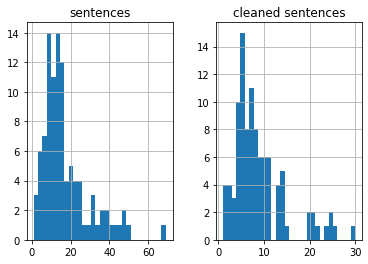

In [141]:
text_word_count = []
summary_word_count = []

for i in rank_df['sent']:
      text_word_count.append(len(i.split()))

for i in rank_df['clean_sent']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'sentences':text_word_count, 'cleaned sentences':summary_word_count})
length_df.hist(bins = 30)
plt.show()

# Paraphrasing


## GPT2 paraphraser
[The library](https://github.com/RussianNLP/russian_paraphrasers) for Russian paraphrase generation trained on data

GPT2-Large [Model](https://huggingface.co/sberbank-ai/rugpt2large) was trained with sequence length 1024 using transformers by SberDevices team on 170Gb data on 64 GPUs 3 weeks.

In [147]:
!pip install --upgrade pip
!pip install -r requirements.txt
!pip install russian_paraphrasers

     |████████████████████████████████| 2.1 MB 5.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [149]:
!pip install git+https://github.com/RussianNLP/russian_paraphrasers@master

  Cloning https://github.com/RussianNLP/russian_paraphrasers (to revision master) to /tmp/pip-req-build-h2ubj2cu
  Running command git clone --filter=blob:none --quiet https://github.com/RussianNLP/russian_paraphrasers /tmp/pip-req-build-h2ubj2cu
  Resolved https://github.com/RussianNLP/russian_paraphrasers to commit 8056005656cfa09215d84ed322a3e9f99f401097
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/Maluuba/nlg-eval.git (to revision master) to /tmp/pip-install-46r3028w/nlg-eval_3b3c4dd672394093b3d9bd80c47a8337
  Running command git clone --filter=blob:none --quiet https://github.com/Maluuba/nlg-eval.git /tmp/pip-install-46r3028w/nlg-eval_3b3c4dd672394093b3d9bd80c47a8337
  Resolved https://github.com/Maluuba/nlg-eval.git to commit 7f7993035a2f4729a15d20040fd904933ea58767
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.7/280.7 KB 7.2 MB/s eta

In [150]:
from russian_paraphrasers import GPTParaphraser

paraphraser = GPTParaphraser(model_name="gpt2", range_cand=False, make_eval=False)

Downloading:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/486 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/765 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.92G [00:00<?, ?B/s]

In [213]:
p = paraphraser.generate(rank_df['sent'][4], n=1, top_k=4, max_length=100, repetition_penalty=1.5)
p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'origin': 'я просто знаю что они бывают и мне уже изначально плохо я как будто живу с бомбой с часовым механизмом и даже не предлагаю никаких идей, не хочу снова все проживать, просто нет сил, а вот эмоции я уже  не отслеживаю просто не приятно, но так описать не могу.',
 'results': [{'predictions': ['Я только точно помню то ощущение когда узнала об их свадьбе']}]}

In [192]:
paraphraser.generate(rank_df['clean_sent'][0], n=1, top_k=4, max_length=50, repetition_penalty=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'origin': 'свои переживания перекладываю стране которую раздирают части хорошего ждать не приходится',
 'results': [{'predictions': ['свои негативные эмоции я переношу на страну, в которой живу']}]}

In [202]:
paraphraser.generate(rank_df['clean_sent'][1], n=5, top_k=10, max_length=50, repetition_penalty=2.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'origin': 'ощущение что теряешь время которого мало параллельно не улучшается тебе наваливается сверху разгребать одновременно',
 'results': [{'predictions': ['ощущение,что упускаешь нечто важное в жизни которое может тебя омолодит..time ne 6',
    'Появились первые признаки того,что времени в обрез и его нужно экономить..show metho',
    'ощущение того,что времени у тебя в обрез и его катастрофически много на это наплеват.sencesu',
    'ощущение того,что упускаешь массу времени которое можно было бы провести с пользо..cd.2 fi',
    'ощущение,что времени в обрез и ты его тратишь невпроворот а потом оно начинает заканчиватьс.']}]}

*The model performs poorly if max_length < 50, as shown below:*

In [203]:
paraphraser.generate(rank_df['clean_sent'][1], n=5, top_k=10, max_length=30, repetition_penalty=2.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'origin': 'ощущение что теряешь время которого мало параллельно не улучшается тебе наваливается сверху разгребать одновременно',
 'results': [{'predictions': ['ощущение того',
    'ощущение того',
    'ощущение будто потеря',
    'ощущение,чт',
    'ощущение,чт']}]}

In [226]:
def extract_res_gpt2_paraphraser(sent, len, samples = 1):
  p = paraphraser.generate(sent, n=samples, top_k=4, max_length=len, repetition_penalty=1.5)
  return p['results'][0]['predictions']

In [228]:
extract_res_gpt2_paraphraser('я просто знаю что они бывают и мне уже изначально плохо', 50, samples = 2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['я знала ты не будешь злиться',
 'я только знала про то,что у меня есть коты но никогда их не видела']

*Conclusion: As we can see, the model changes a bit the context of sentenses, therefore it can lead to inaccurate summaries*

## RUT5-base-paraphraser
A [paraphraser](https://huggingface.co/cointegrated/rut5-base-paraphraser?text=%D0%B7%D0%BD%D0%B0%D1%8E+%D1%87%D1%82%D0%BE+%D0%B1%D1%8B%D0%B2%D0%B0%D1%8E%D1%82+%D0%B8%D0%B7%D0%BD%D0%B0%D1%87%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE+%D0%BF%D0%BB%D0%BE%D1%85%D0%BE+%D0%B6%D0%B8%D0%B2%D1%83+%D0%B1%D0%BE%D0%BC%D0%B1%D0%BE%D0%B9+%D1%87%D0%B0%D1%81%D0%BE%D0%B2%D1%8B%D0%BC+%D0%BC%D0%B5%D1%85%D0%B0%D0%BD%D0%B8%D0%B7%D0%BC%D0%BE%D0%BC+%D0%BD%D0%B5+%D0%BF%D1%80%D0%B5%D0%B4%D0%BB%D0%B0%D0%B3%D0%B0%D1%8E+%D0%BD%D0%B8%D0%BA%D0%B0%D0%BA%D0%B8%D1%85+%D0%B8%D0%B4%D0%B5%D0%B9+%D0%BD%D0%B5+%D1%85%D0%BE%D1%87%D1%83+%D0%BF%D1%80%D0%BE%D0%B6%D0%B8%D0%B2%D0%B0%D1%82%D1%8C+%D1%81%D0%B8%D0%BB+%D1%8D%D0%BC%D0%BE%D1%86%D0%B8%D0%B8+%D0%BD%D0%B5+%D0%BE%D1%82%D1%81%D0%BB%D0%B5%D0%B6%D0%B8%D0%B2%D0%B0%D1%8E+%D0%BD%D0%B5+%D0%BF%D1%80%D0%B8%D1%8F%D1%82%D0%BD%D0%BE+%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D1%82%D1%8C+%D0%BD%D0%B5+%D0%BC%D0%BE%D0%B3%D1%83) for Russian sentences described [here](https://habr.com/ru/post/564916/) trained on Leipzig [Corpus](https://wortschatz.uni-leipzig.de/en/download/Russian).

In [164]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
MODEL_NAME = 'cointegrated/rut5-base-paraphraser'
paraphraser2 = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
paraphrase_tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [178]:
def paraphrase_rut5(text, max_size=50, beams=5, grams=4, do_sample=False):
    x = paraphrase_tokenizer(text, return_tensors='pt', padding=True).to(paraphraser2.device)
    out = paraphraser2.generate(**x, encoder_no_repeat_ngram_size=grams, num_beams=beams, max_length=max_size, do_sample=do_sample)
    return paraphrase_tokenizer.decode(out[0], skip_special_tokens=True)

In [170]:
rank_df['sent'][4]

'я просто знаю что они бывают и мне уже изначально плохо я как будто живу с бомбой с часовым механизмом и даже не предлагаю никаких идей, не хочу снова все проживать, просто нет сил, а вот эмоции я уже  не отслеживаю просто не приятно, но так описать не могу.'

In [189]:
paraphrase_rut5(rank_df['clean_sent'][4])

'Я знаю что происходит изначально не знаю что происходит'

In [191]:
paraphrase_rut5(rank_df['sent'][4], max_size=10)

'Я просто знаю, что они есть'

In [186]:
rank_df['clean_sent'][1]

'ощущение что теряешь время которого мало параллельно не улучшается тебе наваливается сверху разгребать одновременно'

In [204]:
paraphrase_rut5(rank_df['sent'][1], max_size=20)

'Ощущение того, что вы теряете время, которое постоянно'

In [187]:
paraphrase_rut5(rank_df['clean_sent'][1], max_size=20)

'Ощущение что ты теряешь много времени'

# Evaluation 

In [ ]:
def print_n(list_n):
  for i in list_n:
    print(i)
  print()

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge  
r = Rouge()

In [ ]:
!pip install summ-eval

     |████████████████████████████████| 111 kB 5.4 MB/s 
     |████████████████████████████████| 123 kB 35.3 MB/s 
     |████████████████████████████████| 90 kB 9.9 MB/s 
     |████████████████████████████████| 60 kB 6.3 MB/s 
     |████████████████████████████████| 574 kB 52.6 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 132 kB 56.6 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 8.7 MB 512 kB/s 
     |████████████████████████████████| 127 kB 48.4 MB/s 
     |████████████████████████████████| 175 kB 31.9 MB/s 
  Created wheel for moverscore: filename=moverscore-1.0.3-py3-none-any.whl size=7966 sha256=81d59111392802003707a4213eaaebfa94820631ea5c28e1945f65c5e44465a2
  Stored in directory: /root/.cache/pip/wheels/57/48/8c/2934d05194bf99de323ef6015a98c8da46dc010752700341be
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=51e84a6ba8bb7d87ec00451a

In [ ]:
!pip install -U  git+https://github.com/bheinzerling/pyrouge.git'

/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


## ROUGE metric

In [ ]:
import summ_eval

In [ ]:
!export ROUGE_HOME=/usr/local/lib/python3.7/dist-packages/summ_eval/ROUGE-1.5.5/
!pip install -U  git+https://github.com/bheinzerling/pyrouge.git

  Cloning https://github.com/bheinzerling/pyrouge.git to /tmp/pip-req-build-rh89kohd
  Running command git clone -q https://github.com/bheinzerling/pyrouge.git /tmp/pip-req-build-rh89kohd
  Created wheel for pyrouge: filename=pyrouge-0.1.3-py3-none-any.whl size=191924 sha256=e0cd34da7a1b7b412c8a85d767716e39de12cb09047df68b3d5ae12d9a0f67c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-rtyl9xa7/wheels/2f/1c/55/4e264b4e45f2a6f39a50e95cff45e57b54f202db830f125bb2
Successfully built pyrouge


In [ ]:
from pyrouge import Rouge155

# Results

In [ ]:
#parse dialog!!!
def parse_dialog(text):
  df_with_text = pd.DataFrame([text]).set_axis(['text'], axis=1, inplace=False)
  return df_with_text

In [230]:
def summarize_text(text, remove_stop_words = True, num_bull_points=5, len_of_point=50, is_dialog = False):
  if is_dialog:
    parse_dialog(text)
  rank_sent = rank_sentences(text)[:num_bull_points]
  rank_df = pd.DataFrame(rank_sent, columns=['rank', 'sent'])
  if remove_stop_words:
    rank_df['sent'] = rank_df['sent'].apply(lambda x : ''.join([remove_stopwords(r.split()) for r in clean_sent(split_text2(x))]))
  rank_df['summuries'] = rank_df['sent'].apply(lambda x : paraphrase_rut5(x, max_size=len_of_point))
  return rank_df

In [235]:
summarize_text(full_psy_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,rank,sent,summuries
0,0.049499,правильно услышала тревожит именно неопределенность решениях внутри семьи отсутствие возможности договорится,Неопределенность между решениями внутри семьи невозможность договориться
1,0.048077,расскажите подробнее понимаю разные точки зрения какую ситуацию мужем,Скажите мне подробнее о ситуации с мужем
2,0.047891,каждая семья строит свои взаимоотношения единственного верного решения правильно,Все семьи строят свои отношения единственным правильным решением
3,0.047858,домашнее задание хочу дать возможность разобраться своих эмоциях понять что чувствуете каждый возникать ситуация муж затягивать решением маленькая бытовая ситуация записывать дневник ситуацию свои эмоции,Мне нужно разобраться с эмоциями каждый из нас возникает ситуация
4,0.046009,основной работы большой стресс искать новую хотите вернуться киев не можете решить стоит делать также хочется получить поддержку мужа не можете получить той помощи которую рассчитываете,Большой стресс хочется вернуться в киев


In [233]:
summarize_text(full_text, num_bull_points=10, len_of_point=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,rank,sent,summuries
0,0.011984,свои переживания перекладываю стране которую раздирают части хорошего ждать не приходится,Мне не нужно ждать ничего хорошего
1,0.011365,ощущение что теряешь время которого мало параллельно не улучшается тебе наваливается сверху разгребать одновременно,Ощущение что ты теряешь много времени
2,0.011309,думала что начать инвестировать не знаешь думаю что пол года назад параллельно подушкой делать радует что стабильность деньгах смогла научиться управлять немного своими финансами,Мне кажется что я не знаю что делать
3,0.011256,смотрю дырявую финансовую подушку безопасности судорожно понимаю что кроме прочего никакого верного решения,Смотрю в дырявой финансовой подушке безопасности понимаю что никакого
4,0.011244,знаю что бывают изначально плохо живу бомбой часовым механизмом не предлагаю никаких идей не хочу проживать сил эмоции не отслеживаю не приятно описать не могу,Я знаю что происходит изначально не знаю что происходит
5,0.011207,правильно услышала тревожит именно неопределенность решениях внутри семьи отсутствие возможности договорится,Неопределенность между решениями внутри семьи невозможность договориться
6,0.011189,читаю блекауты теории заговора считаю остаток бюджета сколько хватит денег разных условиях жизни думаю пытаюсь выделить деньги английский прилетают дополнительные расходы,Считаю сколько денег хватит на разные условия жизни
7,0.011174,последний момент откладывает раньше не таких критический ситуаций могла подождать делать что хотела ссорились понятно что принимал решение позже проще никого не напрягала случалось понимал что поздно начал шевелится смешно,Последний момент откладывал не такие критические ситуации
8,0.011149,домашнее задание хочу дать возможность разобраться своих эмоциях понять что чувствуете каждый возникать ситуация муж затягивать решением маленькая бытовая ситуация записывать дневник ситуацию свои эмоции,Мне нужно разобраться с эмоциями каждый из нас возникает ситуация
9,0.011136,основной работы большой стресс искать новую хотите вернуться киев не можете решить стоит делать также хочется получить поддержку мужа не можете получить той помощи которую рассчитываете,Большой стресс хочется вернуться в киев


In [236]:
summarize_text(full_cli_text, num_bull_points=3, len_of_point=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,rank,sent,summuries
0,0.015605,свои переживания перекладываю стране которую раздирают части хорошего ждать не приходится,Мне не нужно ждать хорошего
1,0.014798,думала что начать инвестировать не знаешь думаю что пол года назад параллельно подушкой делать радует что стабильность деньгах смогла научиться управлять немного своими финансами,Не знаешь что я думаю что
2,0.014756,ощущение что теряешь время которого мало параллельно не улучшается тебе наваливается сверху разгребать одновременно,Это чувство что ты теряешь


## Visulization

In [242]:
def show_length_difference(df):
  print(df)
  text_word_count = []
  summary_word_count = []

  for i in df['sent']:
      text_word_count.append(len(i.split()))

  for i in df['summuries']:
      summary_word_count.append(len(i.split()))

  length_df = pd.DataFrame({'sentences':text_word_count, 'summary':summary_word_count})
  length_df.hist(bins = df.shape[0])
  plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


       rank  \
0  0.049499   
1  0.048077   
2  0.047891   
3  0.047858   
4  0.046009   
5  0.045446   
6  0.044517   
7  0.044221   
8  0.043576   
9  0.042795   

                                                                                                                                                                                                          sent  \
0                                                                                                 правильно услышала тревожит именно неопределенность решениях внутри семьи отсутствие возможности договорится   
1                                                                                                                                        расскажите подробнее понимаю разные точки зрения какую ситуацию мужем   
2                                                                                                                             каждая семья строит свои взаимоотношения единственного верного решения правиль

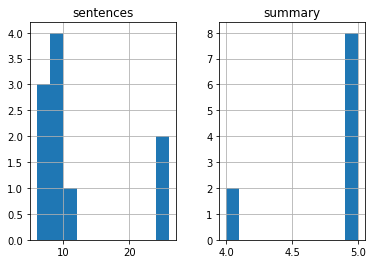

In [243]:
show_length_difference(summarize_text(full_psy_text, num_bull_points=10, len_of_point=10))

# Deployment

In [ ]:
class Summarizer():
    def __init__(self):
        self.conversation_text = None
        self.type_of_summary = None
        self.amount_of_bullet_points = None
        self.max_len_of_point = None
        self.cli_psy_all = None
        self.summary_list = None

    def welcome(self):
        print("Initializing ...")
        time.sleep(2)
        self.conversation_text = str(input("Input dialog text: the text should start with \n \"психолог\" or \"о\" to show clients and psycologists replies independently"))
        time.sleep(3)
    
    def set_settings(self):
        self.type_of_summary = str(input("Press e or a to perform extractive or abstractive summarization: \n "))
        self.amount_of_bullet_points = int(input("Select how many bullet points to display, \n perfect number is from 3 to 7: \n "))
        self.max_len_of_point = int(input("Adjust the max length of bullet points, \n perfect number is from 3 to 20 words: "))
        self.cli_psy_all = str(input("Print \'psy\', \'cli\' or \'all\' to consider \n only psycologist\'s, client\'s replies or all of the replies in summarization: \n "))

    def summarize(self):
       list_t = [self.conversation_text]
       df_texttext = pd.DataFrame(list_t)
       self.summary_list = get_summary_phrases(list_t, extract_summary_t5)
       
    def show_results(self):
        print_n(self.summary_list)
        # def show example 


In [ ]:
s = Summarizer()
s.welcome()
s.set_settings()
s.summarize()
s.show_results()

# while True:
#     s. 
#     bot.user_input()
#     if bot.end_chat:
#         break
#     if bot.is_greeting == False:
#       if bot.is_question == True:
#         bot.bot_answer()
#       else:
#         bot.bot_response() 
#     else: bot.bot_greet()  

In [206]:
t = 'Психолог: хорошо, тогда мы определились с первым заданием и будем понемногу начинать понимать себя, спасибо за встречу.'
list_t = [t]
df_texttext = pd.DataFrame(list_t)
df_texttext

,0
0,"Психолог: хорошо, тогда мы определились с первым заданием и будем понемногу начинать понимать себя, спасибо за встречу."
